# Running an adaptive speciaton model in a static landscape

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from adascape.base import IR12SpeciationModel
from adascape.fastscape_ext import FastscapeElevationTrait

%matplotlib inline

# Build a static landscape

In [2]:
length = (250, 250)
spacing = (1, 1)

x, y = np.meshgrid(*[np.arange(0, l+s, s) for l, s in zip(length, spacing)])

r = np.random.RandomState(0)

environment = x * 10 + r.rand(*y.shape)

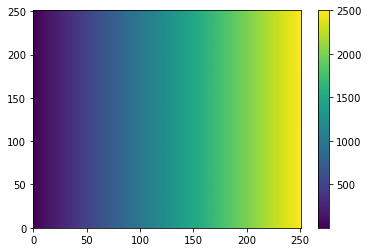

In [3]:
plt.pcolormesh(environment)
plt.colorbar()

# Initialize traits and environmental fields for speciation models

First we initialize one trait associated with elevation where the initial min/max provides the range of trait values that the individual will have and where the slope determines the linear relationship between environmental field and the optimal trait value for each individual on that field.|

In [4]:
trait = FastscapeElevationTrait(topo_elevation=environment,
                                init_trait_min=0.5,
                                init_trait_max=0.5,
                                lin_slope=0.95, 
                                norm_min=environment.min(), 
                                norm_max=environment.max(), 
                                random_seed=1234)
trait.initialize()

# dict of callables to generate initial values for each trait
init_trait_funcs =  {
    'trait': trait.init_trait_func
}

# dict of callables to compute optimal values for each trait
opt_trait_funcs = {
    'trait': trait.opt_trait_func
}

## Functions to compute and plot the solution of the speciation model

In [5]:
def model_run(x=x, y=y, init_trait_funcs=init_trait_funcs, opt_trait_funcs=opt_trait_funcs, 
              num_gen=500, init_abundance=10, dt=1e0, 
              mut_prob=0.005, sigma_mut=0.05, sigma_env_fitness=0.2, sigma_mov=30, sigma_comp_trait=1.0,
              nb_radius=50, car_cap=50, random_seed=1234):
    
    """
    Function to compute the speciation model.
    Parameters
    ----------
    x: array-like
       x coordinates
    y: array-like
       y coordiante
    init_trait_funcs: dict
                      dict of callables to generate initial values for each trait
    opt_trait_funcs: dict
                      dict of callables to compute optimal values for each trait                 
    num_gen: int
             maximum number of generations to compute.
    init_abundance: int
                    initial number of individuals.
    dt: float
        time step of the simulation
    sigma_env_fitnesst: float
                     environmental fitness width.
    mut_prob: float
              mutation probability.
    sigma_mut: float
               trait variability of mutated offspring.
    sigma_mov: float
               dispersal variability of offspring
    sigma_comp_trait: float
                      competition variability based on trait among individuals
    nb_radius: int or float
               Radius of the local neighbourhood
    car_cap: int
             Carrying capacity of individuals in the local neighbourhood
    random_seed: int
                 seed of the random number generator
    """

    # define a speciation model using the specified parameter values
    model = IR12SpeciationModel(grid_x=x, grid_y=y, init_trait_funcs=init_trait_funcs, 
                                 opt_trait_funcs=opt_trait_funcs, init_abundance=init_abundance, 
                                 nb_radius=nb_radius, car_cap=car_cap,
                                 sigma_env_fitness=sigma_env_fitness, sigma_comp_trait=sigma_comp_trait,
                                 sigma_mov=sigma_mov, sigma_mut=sigma_mut,
                                 mut_prob=mut_prob, random_seed=random_seed)
    print(model)
    # initialize the speciation model
    model.initialize()
    # run the speciation model for the number of generations
    dfs = []
    for step in range(num_gen):
        model.evaluate_fitness(dt)
        dfs.append(model.to_dataframe())
        model.update_individuals(dt)
    return pd.concat(dfs)

In [6]:
def plot_sol(dtf, environment, X):
    """
        Plot solution of the model result.

        Parameters
        ----------
        dtf: pd.DataFrame
             with results of the speciation model
        environment: array-like
                     environmental field
        X: array-like
           x coordinate
        """
    num_gen = dtf.step.unique().size
    fig1, axs1 = plt.subplots(2, 2, sharex="col", figsize=(12, 6))
    axs1[0, 0].plot(dtf.groupby('step').size())
    h, xedge, yedge, _ = axs1[1, 0].hist2d(x=dtf['step'], y=dtf['trait_0'],
                                           range=((0, num_gen), (0, 1)),
                                           bins=(num_gen, 100), cmap='bone_r')
    axs1[0, 1].pcolormesh(environment)
    axs1[0, 1].scatter(dtf['x'].loc[dtf['step'] == max(dtf['step'])],
                       dtf['y'].loc[dtf['step'] == max(dtf['step'])],
                       c=dtf['trait_0'].loc[dtf['step'] == max(dtf['step'])],
                       edgecolor='w', vmin=0, vmax=1)
    h, xedge, yedge, _ = axs1[1, 1].hist2d(x=dtf['x'].loc[dtf['step'] == max(dtf['step'])],
                                           y=dtf['trait_0'].loc[dtf['step'] == max(dtf['step'])],
                                           range=((0, X.max()), (0, 1)),
                                           bins=(25, 250), cmap='bone_r')
    axs1[0, 1].yaxis.set_label_position("right")
    axs1[0, 1].yaxis.tick_right()
    axs1[1, 1].yaxis.set_label_position("right")
    axs1[1, 1].yaxis.tick_right()
    axs1[0, 1].set_ylabel('Y', weight='bold')
    axs1[0, 0].set_ylabel('Abundance (No. ind)', weight='bold')
    axs1[1, 1].set_ylabel('Trait', weight='bold')
    axs1[1, 0].set_ylabel('Trait', weight='bold')
    axs1[1, 1].set_xlabel('X', weight='bold')
    axs1[1, 0].set_xlabel('Time (generations)', weight='bold')


In [7]:
def plot_spatial_dist(df, environment):
    """
    Plot spatial distribution of individuals over the environemnt in selected time steps.

    Parameters
    ----------
    df: pd.DataFrame
         with results of the speciation model
    environment: array-like
                 environmental field
    """
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex='col', sharey='row', figsize=(12, 6))
    for ax, print_step in zip(axes.ravel(), np.linspace(0, df.step.unique().size - 1, 10).astype(int)):
        pop = df.groupby('step').get_group(print_step)
        ax.pcolormesh(environment)
        ax.scatter(pop.x, pop.y, c=pop.trait_0, edgecolor='w', vmin=0, vmax=1)
        ax.set_title(f't = {print_step}, size = {len(pop)}')
    fig.tight_layout()


## Speciation model without trait-mediated competition

In [8]:
%time df1 = model_run()
df1

<IR12SpeciationModel (individuals: not initialized)>
Parameters:
    lifespan: None
    random_seed: 1234
    always_direct_parent: True
    on_extinction: warn
    taxon_threshold: 0.05
    taxon_def: traits
    rho: 0
    nb_radius: 50
    car_cap: 50
    sigma_env_fitness: 0.2
    sigma_mov: 30
    sigma_mut: 0.05
    mut_prob: 0.005
    sigma_comp_trait: 1.0



/Users/acevedo/opt/anaconda3/envs/adascape-dev/lib/python3.10/site-packages/scipy/cluster/vq.py:603: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


CPU times: user 3min 48s, sys: 6.9 s, total: 3min 55s
Wall time: 15.1 s


,step,time,dt,x,y,taxon_id,ancestor_id,n_offspring,fitness,n_all,n_eff,trait_0
0,0,0.0,0.0,244.174942,110.251531,1.0,0.0,4,0.077659,1,1.000000,0.500000
1,0,0.0,0.0,95.048934,152.467702,1.0,0.0,14,0.850503,3,3.000000,0.500000
2,0,0.0,0.0,230.811558,215.905324,1.0,0.0,7,0.131565,1,1.000000,0.500000
3,0,0.0,0.0,65.423106,215.939418,1.0,0.0,7,0.522451,4,4.000000,0.500000
4,0,0.0,0.0,79.774265,168.720328,1.0,0.0,9,0.694510,4,4.000000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
400,499,499.0,0.0,41.397831,10.945102,1623.0,1618.0,1,0.883656,35,34.813766,0.081265
401,499,499.0,0.0,24.448538,46.673816,1623.0,1618.0,1,0.984687,53,52.899403,0.081265
402,499,499.0,0.0,14.999972,82.027217,1623.0,1618.0,1,0.999985,46,45.876688,0.081265
403,499,499.0,0.0,85.462205,90.048926,1623.0,1618.0,1,0.410999,36,34.520453,0.081265


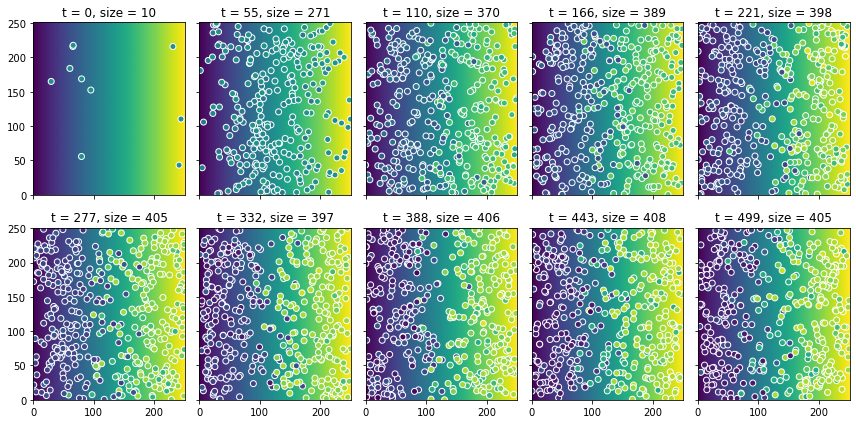

In [9]:
plot_spatial_dist(df1, environment)

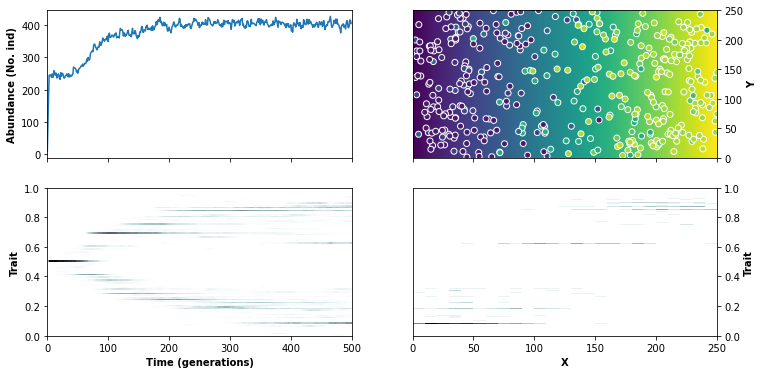

In [10]:
plot_sol(df1, environment, x)

## Speciation model with trait-mediated competition

In [11]:
%time df2 = model_run(sigma_comp_trait=0.20, car_cap=30)
df2

<IR12SpeciationModel (individuals: not initialized)>
Parameters:
    lifespan: None
    random_seed: 1234
    always_direct_parent: True
    on_extinction: warn
    taxon_threshold: 0.05
    taxon_def: traits
    rho: 0
    nb_radius: 50
    car_cap: 30
    sigma_env_fitness: 0.2
    sigma_mov: 30
    sigma_mut: 0.05
    mut_prob: 0.005
    sigma_comp_trait: 0.2



/Users/acevedo/opt/anaconda3/envs/adascape-dev/lib/python3.10/site-packages/scipy/cluster/vq.py:603: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


CPU times: user 3min 2s, sys: 4.4 s, total: 3min 6s
Wall time: 11.9 s


,step,time,dt,x,y,taxon_id,ancestor_id,n_offspring,fitness,n_all,n_eff,trait_0
0,0,0.0,0.0,244.174942,110.251531,1.0,0.0,2,0.077659,1,1.000000,0.500000
1,0,0.0,0.0,95.048934,152.467702,1.0,0.0,9,0.850503,3,3.000000,0.500000
2,0,0.0,0.0,230.811558,215.905324,1.0,0.0,4,0.131565,1,1.000000,0.500000
3,0,0.0,0.0,65.423106,215.939418,1.0,0.0,4,0.522451,4,4.000000,0.500000
4,0,0.0,0.0,79.774265,168.720328,1.0,0.0,5,0.694510,4,4.000000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
347,499,499.0,0.0,144.788950,22.679586,3100.0,3091.0,1,0.904631,40,22.079644,0.665409
348,499,499.0,0.0,141.544262,104.306140,3100.0,3091.0,1,0.880841,39,24.963949,0.665409
349,499,499.0,0.0,222.148776,120.777246,3100.0,3091.0,1,0.597217,39,26.658620,0.665409
350,499,499.0,0.0,208.726264,19.259479,3100.0,3091.0,1,0.744554,38,23.162664,0.665409


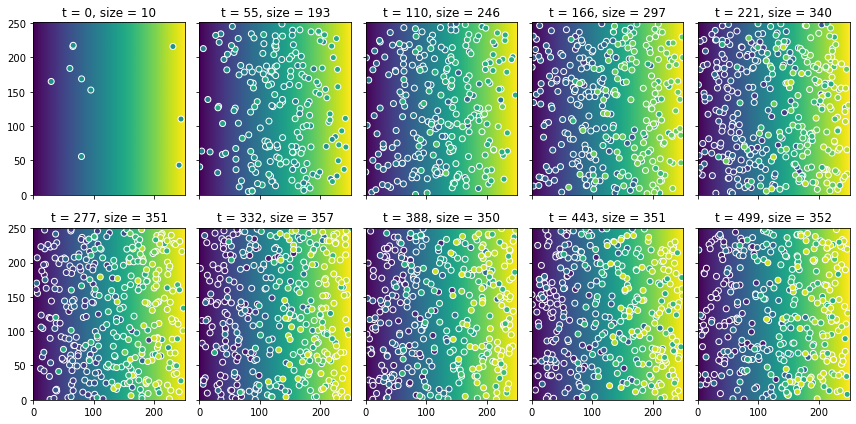

In [12]:
plot_spatial_dist(df2, environment)

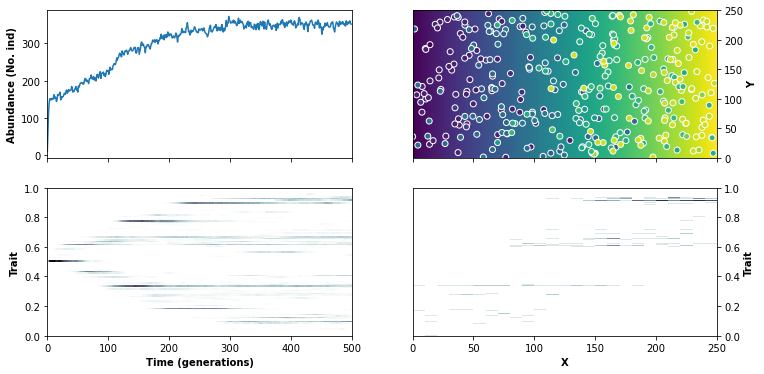

In [13]:
plot_sol(df2, environment, x)